In [ ]:
import json
import h5py
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import seaborn as sns

In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Load JSON data
with open('/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/sarcasm_data.json', 'r') as f:
    sarcasm_data = json.load(f)

In [ ]:
# Initialize tokenizer and model, move BERT model to the GPU
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

def encode_text(text):
    # Tokenize text and move inputs to the device
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():  # No gradients required for encoding
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Mean pooling

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def load_hdf5_features(hdf5_path):
    with h5py.File(hdf5_path, "r") as hdf5_file:
        features = {key: torch.tensor(hdf5_file[key][:]).to(device) for key in hdf5_file.keys()}
    return features

utterance_visual_path = "/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/features/utterances_final/resnet_pool5.hdf5"
context_visual_path = "/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/features/context_final/resnet_pool5.hdf5"

utterance_visual_features = load_hdf5_features(utterance_visual_path)
context_visual_features = load_hdf5_features(context_visual_path)

# Normalize visual features
def normalize_features(features):
    for key in features:
        features[key] = (features[key] - features[key].mean()) / features[key].std()
    return features

utterance_visual_features = normalize_features(utterance_visual_features)
context_visual_features = normalize_features(context_visual_features)

In [ ]:
encoded_data = []
for key, value in sarcasm_data.items():
    utterance_text = encode_text(value["utterance"])
    context_text = encode_text(" ".join(value["context"]))

    utterance_visual = utterance_visual_features[key]
    context_visual = context_visual_features[key]

    sarcasm_label = torch.tensor(value["sarcasm"], dtype=torch.long).to(device)

    encoded_data.append({
        "utterance_text": utterance_text,
        "context_text": context_text,
        "utterance_visual": utterance_visual,
        "context_visual": context_visual,
        "sarcasm": sarcasm_label
    })

In [ ]:
class MultimodalSarcasmDetector(nn.Module):
    def __init__(self, text_dim, visual_dim, hidden_dim, num_classes):
        super(MultimodalSarcasmDetector, self).__init__()
        self.text_fc = nn.Linear(text_dim, hidden_dim)
        self.visual_fc = nn.Linear(visual_dim, hidden_dim)
        self.fusion_fc = nn.Linear(2 * hidden_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes),
        )

    def forward(self, text_features, visual_features):
        # Process text features
        text_encoded = torch.relu(self.text_fc(text_features))

        # Mean pooling for padded visual features
        visual_pooled = visual_features.mean(dim=1)
        visual_encoded = torch.relu(self.visual_fc(visual_pooled))

        # Fusion and classification
        fused = torch.cat((text_encoded, visual_encoded), dim=1)
        fused = torch.relu(self.fusion_fc(fused))
        return self.classifier(fused)

# Initialize model, move to GPU
TEXT_DIM = 768
VISUAL_DIM = 2048
HIDDEN_DIM = 32
NUM_CLASSES = 2
model = MultimodalSarcasmDetector(TEXT_DIM, VISUAL_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
class SarcasmDataset(Dataset):
    def __init__(self, encoded_data):
        self.data = encoded_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return (
            item["utterance_text"].squeeze(0),  # Remove extra dimension
            item["utterance_visual"],
            item["sarcasm"]
        )

def custom_collate_fn(batch):
    # Separate features and labels
    text_features = [item[0] for item in batch]
    visual_features = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    # Stack text features
    text_features = torch.stack(text_features)

    # Pad visual features along the first dimension
    padded_visual_features = pad_sequence(visual_features, batch_first=True)

    # Stack labels
    labels = torch.stack(labels)

    return text_features, padded_visual_features, labels

train_data, temp_data = train_test_split(encoded_data, test_size=0.3, random_state=11)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=11)

# You can now create new datasets from the split data
train_dataset = SarcasmDataset(train_data)
val_dataset = SarcasmDataset(val_data)
test_dataset = SarcasmDataset(test_data)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=custom_collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=custom_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=custom_collate_fn
)

In [ ]:
best_val_acc = 0  # To track the best validation accuracy

for epoch in range(20):  # Number of epochs
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training loop
    for text_features, visual_features, labels in train_dataloader:
        # Move data to device
        text_features = text_features.to(device)
        visual_features = visual_features.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(text_features, visual_features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    # Validation loop after each epoch
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for text_features, visual_features, labels in val_dataloader:
            text_features = text_features.to(device)
            visual_features = visual_features.to(device)
            labels = labels.to(device)

            outputs = model(text_features, visual_features)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Training Accuracy: {correct / total:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model

Epoch 1, Loss: 11.1023, Training Accuracy: 0.4886, Validation Accuracy: 0.5437
Epoch 2, Loss: 11.0185, Training Accuracy: 0.5093, Validation Accuracy: 0.5825
Epoch 3, Loss: 10.9221, Training Accuracy: 0.6004, Validation Accuracy: 0.6796
Epoch 4, Loss: 10.8522, Training Accuracy: 0.6253, Validation Accuracy: 0.6796
Epoch 5, Loss: 10.8818, Training Accuracy: 0.5901, Validation Accuracy: 0.6990
Epoch 6, Loss: 10.6359, Training Accuracy: 0.6439, Validation Accuracy: 0.6796
Epoch 7, Loss: 10.5925, Training Accuracy: 0.6542, Validation Accuracy: 0.6990
Epoch 8, Loss: 10.5607, Training Accuracy: 0.6687, Validation Accuracy: 0.6990
Epoch 9, Loss: 10.3715, Training Accuracy: 0.6542, Validation Accuracy: 0.7184
Epoch 10, Loss: 10.3329, Training Accuracy: 0.6812, Validation Accuracy: 0.7184
Epoch 11, Loss: 10.3847, Training Accuracy: 0.6729, Validation Accuracy: 0.7087
Epoch 12, Loss: 10.2364, Training Accuracy: 0.6501, Validation Accuracy: 0.7476
Epoch 13, Loss: 10.1486, Training Accuracy: 0.695

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# Test loop
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for text_features, visual_features, labels in test_dataloader:
        # Move data to device
        text_features = text_features.to(device)
        visual_features = visual_features.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(text_features, visual_features)
        probabilities = F.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs, 1)  # Predicted class

        # Collect labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability for positive class

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [ ]:
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Precision
precision = precision_score(all_labels, all_preds)

# Recall
recall = recall_score(all_labels, all_preds)

# F1 Score
f1 = f1_score(all_labels, all_preds)

# AUC-ROC
roc_auc = roc_auc_score(all_labels, all_probs)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.6731
Precision: 0.7027
Recall: 0.5306
F1 Score: 0.6047
AUC-ROC: 0.7369


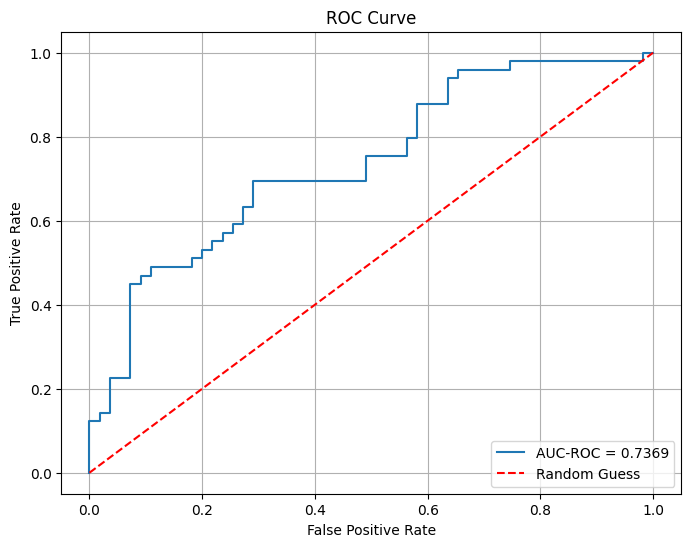

In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

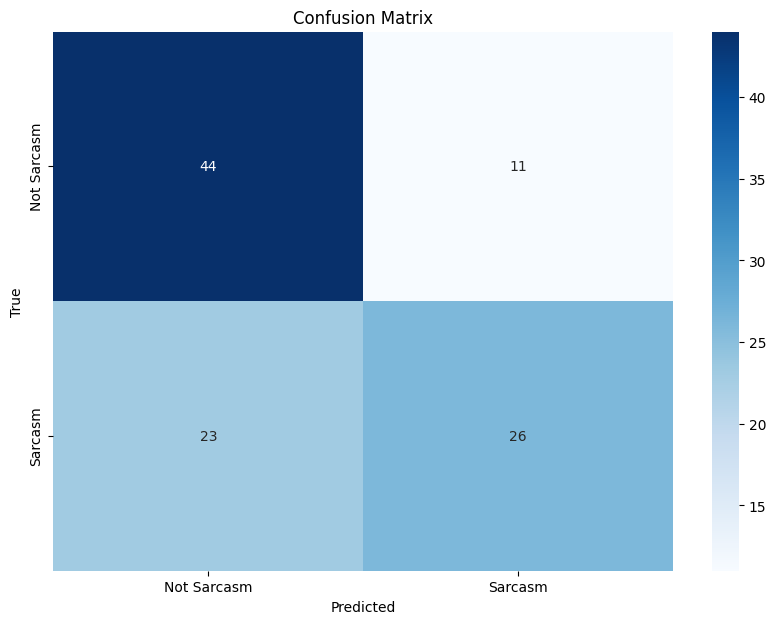

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(all_labels, all_preds, class_names=["Not Sarcasm", "Sarcasm"])